# SISSO for ELASTIC CONSTANTS

This notebook reads results obtained by the SISSO models availbles in data/fromHPRC/ and plot SISSO calculated vs DFT values of the elastic constants in the training dataset, using all data, a CV folds 5 and a CV folds 10

In [2]:
import pandas as pd
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.font_manager
import os
from sklearn.metrics import mean_squared_error

%matplotlib inline


plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})
plt.rc('mathtext', fontset="cm")

In [3]:
dpi=500
res_f='../results'

In [4]:
d_f='../data/'

In [5]:
import scipy.stats as stats
import os
import matplotlib.colors as mcolors

In [6]:
colorm=['r','g','y','b','purple','gray','teal']
case=['C_11','C_12','C_44','K','G','E','v']
case_latex=['C_{11}','C_{12}','C_{44}','K','G','E','\nu']

##### Functionm to retrieve feature frequency

In [7]:
strings="atomic_number_avg atomic_number_red atomic_number_diff atomic_radius_avg atomic_radius_red atomic_radius_diff en_pauling_avg en_pauling_red en_pauling_diff density_avg density_red density_diff electron_affinity_avg electron_affinity_red electron_affinity_diff en_allen_avg en_allen_red en_allen_diff heat_of_formation_avg heat_of_formation_red heat_of_formation_diff lattice_constant_avg lattice_constant_red lattice_constant_diff melting_point_avg melting_point_red melting_point_diff period_avg period_red period_diff valence_avg valence_red valence_diff"

strings=strings.split()
strings_lat=[r'$Z_{avg}$',
             r'$Z_{red}$', 
             r'$Z_{diff}$',
             r'$r_{a,avg}$',
             r'$r_{a,red}$',
             r'$r_{a,diff}$',
             r'$\chi_{Pauling,avg}$',
             r'$\chi_{Pauling,red}$',
             r'$\chi_{Pauling,diff}$',
             r'$\rho_{avg}$',
             r'$\rho_{red}$',
             r'$\rho_{diff}$',
             r'$E_{ea,avg}$',
             r'$E_{ea,red}$',
             r'$E_{ea,diff}$',
             r'$\chi_{Allen,avg}$',
             r'$\chi_{Allen,red}$',
             r'$\chi_{Allen,diff}$',
             r'$\Delta H_{f,avg}$',
             r'$\Delta H_{f,red}$',
             r'$\Delta H_{f,diff}$',
             r'$a_{avg}$',
             r'$a_{red}$',
             r'$a_{diff}$',
             r'$T_{m,avg}$',
             r'$T_{m,red}$',
             r'$T_{m,diff}$',
             r'$P_{avg}$',
             r'$P_{red}$',
             r'$P_{diff}$',
             r'$VEC_{avg}$',
             r'$VEC_{red}$',
             r'$VEC_{diff}$',]

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)


by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
feat_col=[0]*len(strings)

int_n=int(len(sorted_names)/len(strings))

for ci,i in enumerate(range(0,int_n*len(strings),int_n)):
    feat_col[ci]=sorted_names[i]
    

def get4Dfreq(directory,dim):
    cwd = os.getcwd()
    os.chdir(directory)
    dirs=[]

    sisso=[[[]for j in range(i+1)] for i in range(4)]

    for x,i,z in os.walk(".",topdown=True):
        dirs = [d for d in i]
        dirs.sort()

        break
    for i in dirs:
        os.chdir(i)

        for n in range(dim):
            pattern = str(n+1)+"D descriptor"
            with open('SISSO.out') as file:
                all_lines = file.readlines()
                for current_line_no, current_line in enumerate(all_lines):
                    if pattern in current_line:
                        for k in range(n+1):


                            sisso[n][k-1].append(all_lines[current_line_no+3+k].split(':')[1])

                        break
        os.chdir('..')
    os.chdir('..')
    count_s=[0]*len(strings)
    vv=[]
    ll=[]
    for i in range(dim):
        v_j=[]
        l_j=[]
        for j in range(i+1):
            count_s=[0]*len(strings)
            for s_i in sisso[i][j]:

                for ss in range(len(strings)):
                    if strings[ss] in s_i:
                        count_s[ss]=count_s[ss]+1
            
            inds=[idx for idx, val in enumerate(count_s) if val != 0]
            count_s=np.array(count_s)
            np_str=np.array(strings,dtype=str)
            values=count_s[inds]
            labels=np_str[inds]
            
            


            sor_v=values.argsort()
            
            values=[values[i] for i in sor_v]
            labels=[labels[i] for i in sor_v]
            values.reverse()
            labels.reverse()

            indexes = np.arange(len(labels))
            width = 0.5

            v_j.append(values)
            l_j.append(labels)

        vv.append(v_j)
        ll.append(l_j)
    val_mm=[]
    lab_mm=[]
    for n in range(dim):

        new_val=[]
        val=vv[n]
        lab=ll[n][:]
        maxi=0
        for i in val:
            if len(i)> maxi:
                maxi=len(i)
        for ii,i in enumerate(val):
            ai=np.zeros(maxi-len(i),dtype=int)
            
            
            new_val.append(np.concatenate((i,ai)))
            
            lab[ii]=lab[ii]+['']*(maxi-len(i))
        val=np.vstack(new_val)

        imp_lab=[x[:] for x in lab]
        imp_col=[x[:] for x in lab]
        for cii,ii in enumerate(lab):
            for ci,i in enumerate(ii):
                
                if i == '':
                    imp_col[cii][ci]='k'
                    next
                else:
                    imp_col[cii][ci]=feat_col[strings.index(i)]
                    imp_lab[cii][ci]=strings_lat[strings.index(i)]
        lab_master=[]
        for mi in range(len(lab)):
            lab_master=lab_master+lab[mi]

        lab_master=list(set(lab_master))
        if '' in lab_master:
            lab_master.remove('')

        lab_np=np.array(lab)
        val_np=np.array(val)

        val_master=[0]*len(lab_master)
        for n_i,i in enumerate(lab_master):

            ind=np.where(lab_np==i)
            
            ind =list(zip(ind[0], ind[1]))
            for i_ind in ind:
                
                val_master[n_i]=val_master[n_i]+val_np[i_ind[0],i_ind[1]]
            
        val_master=np.array(val_master)
        sor_v=val_master.argsort()
        
        val_master=[val_master[i] for i in sor_v]
        lab_master=[lab_master[i] for i in sor_v]
        val_master.reverse()
        lab_master.reverse()




        lab_mm.append(lab_master)
        val_mm.append(val_master)
        
        
        
        new_val=[]
        val=val_mm
        lab=lab_mm
        maxi=0
        for i in val:
            if len(i)> maxi:
                maxi=len(i)
        for ii,i in enumerate(val):
            ai=np.zeros(maxi-len(i),dtype=int)
            new_val.append(np.concatenate((i,ai)))
            lab[ii]=lab[ii]+['']*(maxi-len(i))
        val=np.vstack(new_val)
        
        
        
        
        imp_lab=[x[:] for x in lab]
        imp_col=[x[:] for x in lab]
        for cii,ii in enumerate(lab):
            for ci,i in enumerate(ii):
                if i == '':
                    imp_col[cii][ci]='k'
                    next
                else:
                    imp_col[cii][ci]=feat_col[strings.index(i)]
                    imp_lab[cii][ci]=strings_lat[strings.index(i)]
    os.chdir(cwd)
    return(lab_mm,val_mm,imp_col,imp_lab)

## only 3D

## 5 fold CVs

plots for parity plot, error distribution and feature frequency for the 3D model

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151,

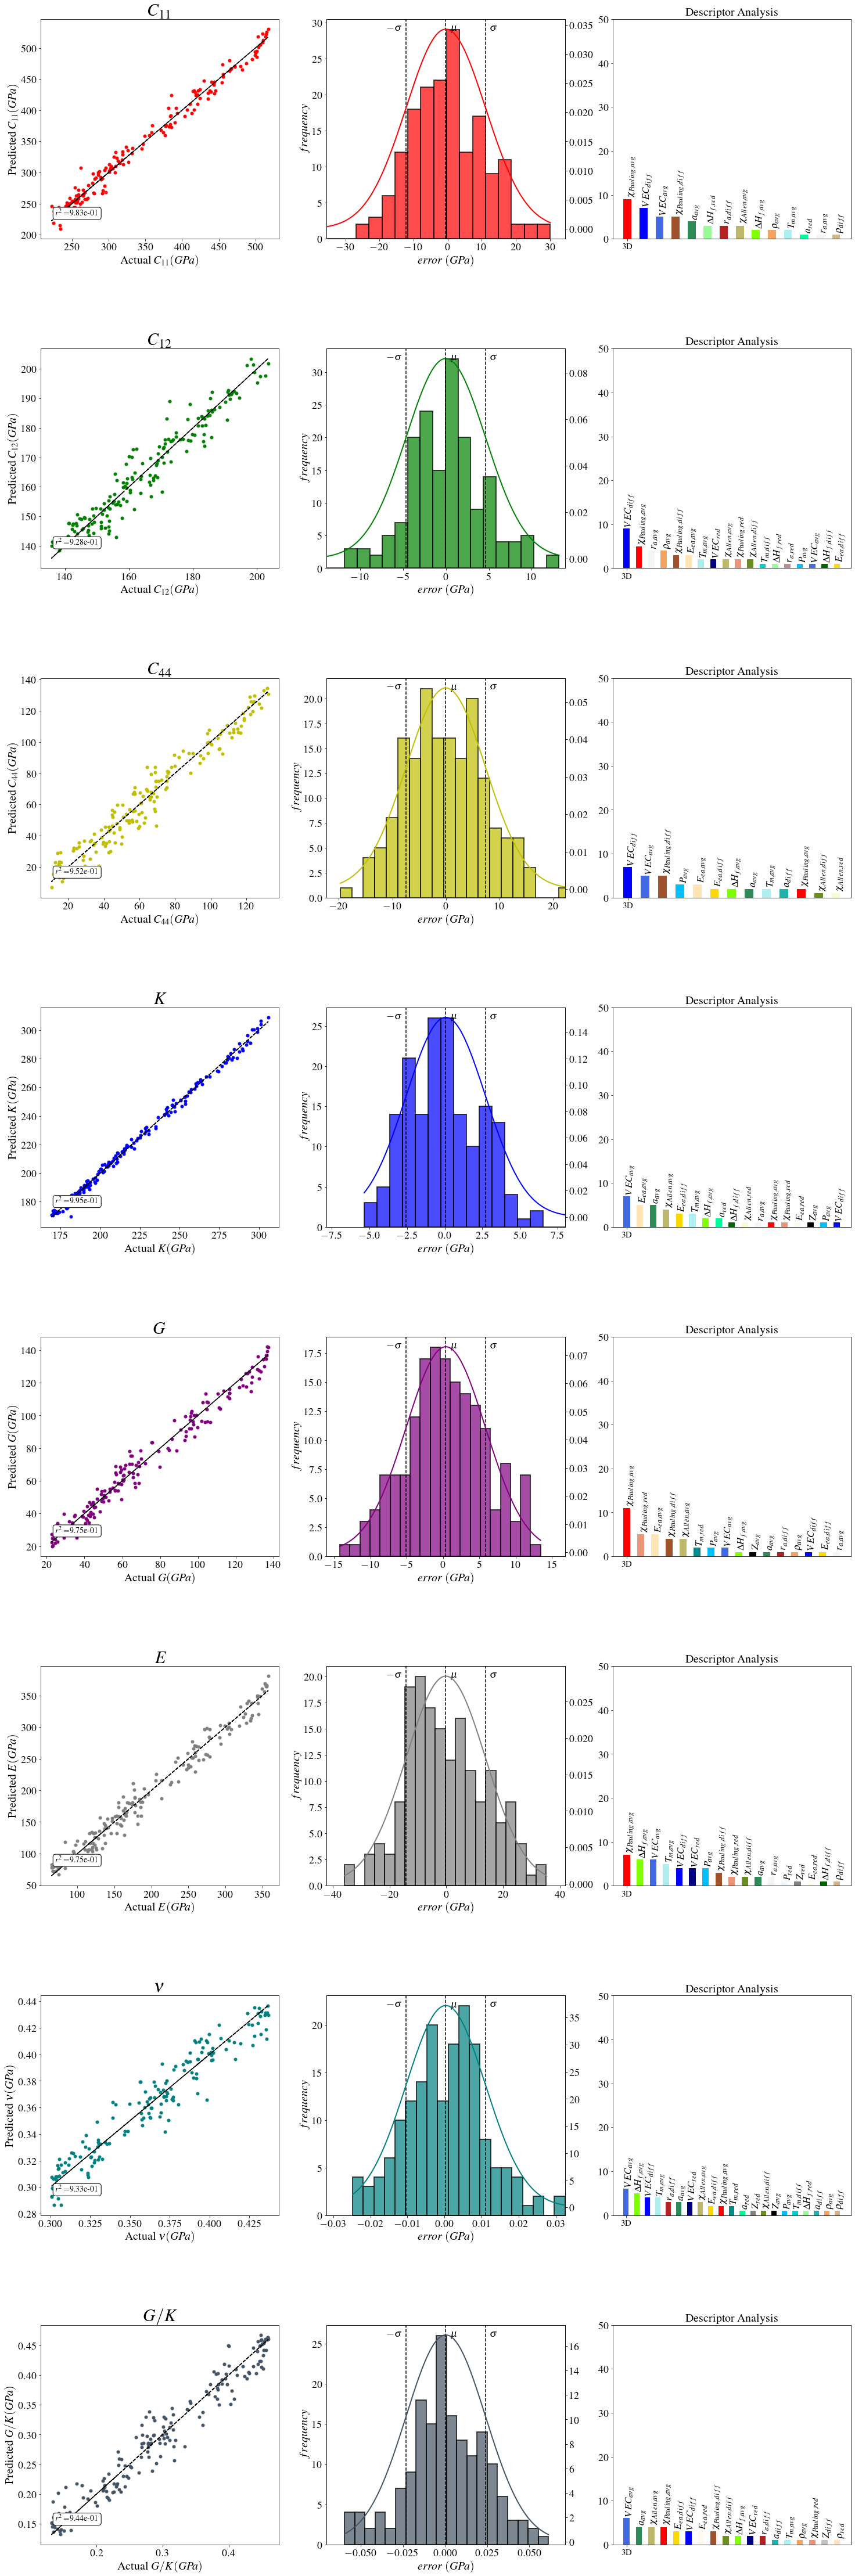

In [10]:
CVcase='05'
fs=20
colorm=['r','g','y','b','purple','gray','teal','#445464']

fig, ax = plt.subplots(8,3,figsize=(25,80))
plt.subplots_adjust(hspace = 0.5,)
c=0
case=['C_11','C_12','C_44','K','G','E','v','GK']
for i in range(8):
    j=0
    df=pd.read_csv(d_f+'fromHPRC/'+case[c]+'.avgvar'+CVcase+'/Results3D', delim_whitespace=True)
    ax[i,j].scatter(df['Y'],df['Y_pred'],color=colorm[c],s=25)
    ax[i,j].plot(df['Y'],df['Y'],'--k')
    ax[i,j].annotate(r'$r^2=$'+'{:.2e}'.format(round(r2_score(df['Y'],df['Y_pred']),4))
                     , xy=(100, 50), xycoords='axes points',
        size=14, ha='right', va='top',
        bbox=dict(boxstyle='round', fc='w'))
    j=1
    label=df['diff']
    label=np.sort(label)
    yh,xh,_=ax[i,j].hist(label, 20,edgecolor='k',color=colorm[c], linewidth=2,alpha=0.7)
    ax2=ax[i,j].twinx()
    x=np.arange(label.min(),label.max(),0.0001)
    y=stats.norm.pdf(x,label.mean(),label.std())
    print(np.where(y>1))
    
    scale=1.5*yh.max()/y.max()
    ax2.plot(x,y,'-',color=colorm[c], linewidth=2)
    
    frame1 = plt.gca()
    
    left = frame1.axes.spines["left"]
    right_side = frame1.axes.spines["right"]
    top = frame1.axes.spines["top"]

    ax[i,j].set_ylabel(r'$frequency$',fontsize=20)
    ax[i,j].set_xlabel(r'$error$ $(GPa)$',fontsize=20)


    ####
    ax[i,j].axvline(label.mean(),color='k',ls='--')
    ax[i,j].annotate(r'$\mu$',xy=(0.52, 0.95),xycoords='axes fraction')
    ax[i,j].axvline(label.mean()-label.std(),color='k',ls='--')
    ax[i,j].annotate(r'$-\sigma$',xy=(0.5 - (1/6) - 0.08, 0.95),xycoords='axes fraction')
    ax[i,j].axvline(label.mean()+label.std(),color='k',ls='--')
    ax[i,j].annotate(r'$\sigma$',xy=(0.5 + (1/6) + 0.02, 0.95),xycoords='axes fraction')
    ax[i,j].set_xlim([label.mean()-3*label.std(),label.mean()+3*label.std()])
    ####
    j=2

    
    lab_mm,val_mm,imp_col,imp_lab=get4Dfreq(d_f+'fromHPRC/'+case[c]+'.avgvar'+CVcase+'/',3)
    l_plot = ['3D']
    co=0
    x=[]
    width = 0.5  # the width of the bars

    for ii in range(2,len(val_mm)):
        for jj in range(len(val_mm[ii])):
            ax[i,j].bar(co,val_mm[ii][jj],width=width,color=imp_col[ii][jj])
            ax[i,j].annotate(#'{}'.format(height),
            '{}'.format(imp_lab[ii][jj]),
            xy=(co + width / 2, val_mm[ii][jj]),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom',rotation=90, fontsize=17)
            co=co+1
        if ii !=len(val_mm)-1:
            plt.axvline(co,color='k')
        x.append(co-len(val_mm[ii]))
        co=co+1
    ax[i,j].set_title(r'Descriptor Analysis',fontsize=20)
    ax[i,j].set_xticks(x)
    ax[i,j].set_xticklabels(l_plot,fontsize=15)
    ax[i,j].set_ylim(0,50)
    
    
    
    
    
    
    c=c+1
    
case_latex=['C_{11}','C_{12}','C_{44}','K','G','E','\\nu','G/K']
c=0
for i in range(8):
    j=0
    ax[i,j].set_xlabel('Actual $'+case_latex[c]+'(GPa)$', fontsize=fs)
    ax[i,j].set_ylabel('Predicted $'+case_latex[c]+'(GPa)$', fontsize=fs)
    ax[i,j].set_title('$'+case_latex[c]+'$', fontsize=fs+10)
    c=c+1

## 10 CVs fold

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151,

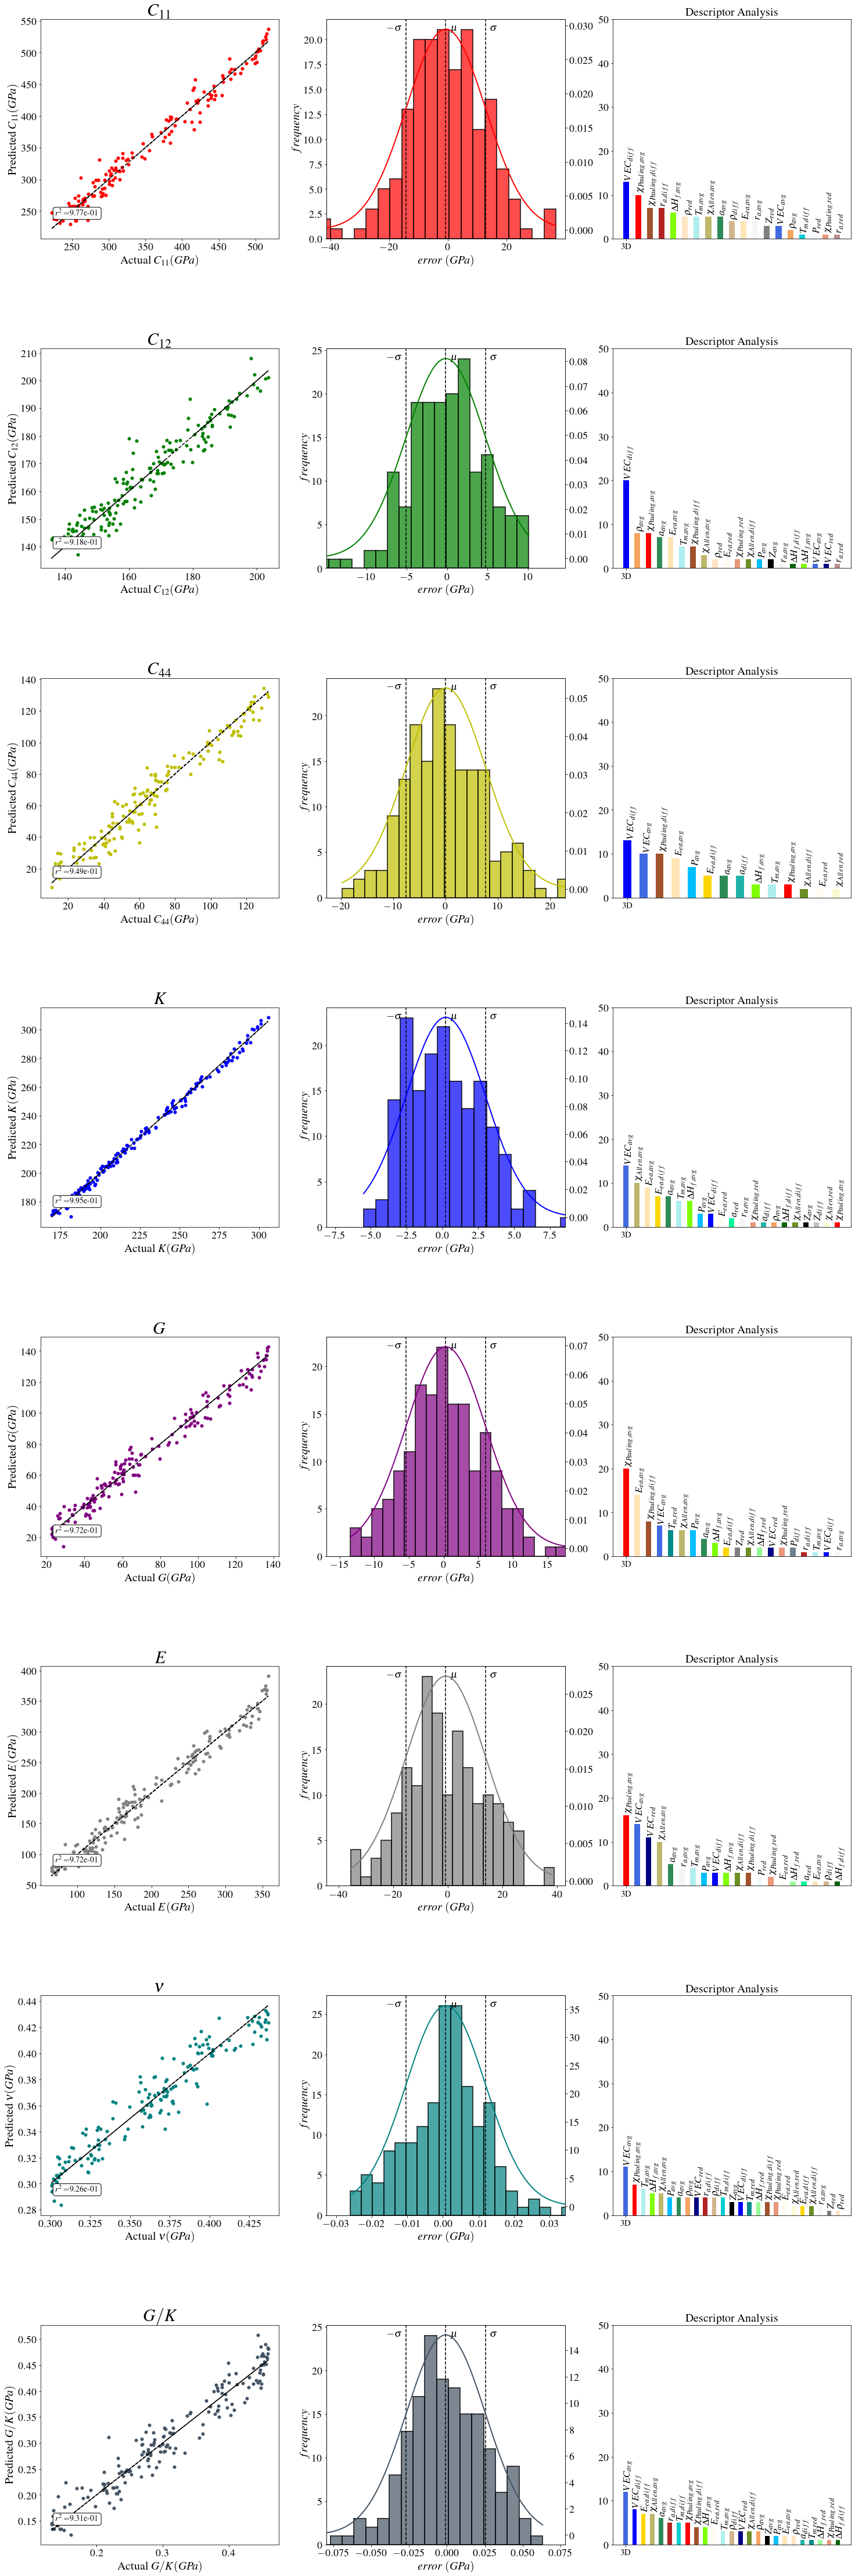

In [11]:
CVcase='10'
fs=20
colorm=['r','g','y','b','purple','gray','teal','#445464']

fig, ax = plt.subplots(8,3,figsize=(25,80))
plt.subplots_adjust(hspace = 0.5,)
c=0
case=['C_11','C_12','C_44','K','G','E','v','GK']
for i in range(8):
    j=0
    df=pd.read_csv(d_f+'fromHPRC/'+case[c]+'.avgvar'+CVcase+'/Results3D', delim_whitespace=True)
    ax[i,j].scatter(df['Y'],df['Y_pred'],color=colorm[c],s=25)
    ax[i,j].plot(df['Y'],df['Y'],'--k')
    ax[i,j].annotate(r'$r^2=$'+'{:.2e}'.format(round(r2_score(df['Y'],df['Y_pred']),4))
                     , xy=(100, 50), xycoords='axes points',
        size=14, ha='right', va='top',
        bbox=dict(boxstyle='round', fc='w'))
    j=1
    label=df['diff']
    label=np.sort(label)
    yh,xh,_=ax[i,j].hist(label, 20,edgecolor='k',color=colorm[c], linewidth=2,alpha=0.7)
    ax2=ax[i,j].twinx()
    x=np.arange(label.min(),label.max(),0.0001)
    y=stats.norm.pdf(x,label.mean(),label.std())
    print(np.where(y>1))
    
    scale=1.5*yh.max()/y.max()
    ax2.plot(x,y,'-',color=colorm[c], linewidth=2)
    
    frame1 = plt.gca()
    
    left = frame1.axes.spines["left"]
    right_side = frame1.axes.spines["right"]
    top = frame1.axes.spines["top"]

    ax[i,j].set_ylabel(r'$frequency$',fontsize=20)
    ax[i,j].set_xlabel(r'$error$ $(GPa)$',fontsize=20)


    ####
    ax[i,j].axvline(label.mean(),color='k',ls='--')
    ax[i,j].annotate(r'$\mu$',xy=(0.52, 0.95),xycoords='axes fraction')
    ax[i,j].axvline(label.mean()-label.std(),color='k',ls='--')
    ax[i,j].annotate(r'$-\sigma$',xy=(0.5 - (1/6) - 0.08, 0.95),xycoords='axes fraction')
    ax[i,j].axvline(label.mean()+label.std(),color='k',ls='--')
    ax[i,j].annotate(r'$\sigma$',xy=(0.5 + (1/6) + 0.02, 0.95),xycoords='axes fraction')
    ax[i,j].set_xlim([label.mean()-3*label.std(),label.mean()+3*label.std()])
    ####
    j=2

    
    lab_mm,val_mm,imp_col,imp_lab=get4Dfreq(d_f+'fromHPRC/'+case[c]+'.avgvar'+CVcase+'/',3)
    l_plot = ['3D']
    co=0
    x=[]
    width = 0.5  # the width of the bars

    for ii in range(2,len(val_mm)):
        for jj in range(len(val_mm[ii])):
            ax[i,j].bar(co,val_mm[ii][jj],width=width,color=imp_col[ii][jj])
            ax[i,j].annotate(#'{}'.format(height),
            '{}'.format(imp_lab[ii][jj]),
            xy=(co + width / 2, val_mm[ii][jj]),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom',rotation=90, fontsize=17)
            co=co+1
        if ii !=len(val_mm)-1:
            plt.axvline(co,color='k')
        x.append(co-len(val_mm[ii]))
        co=co+1
    ax[i,j].set_title(r'Descriptor Analysis',fontsize=20)
    ax[i,j].set_xticks(x)
    ax[i,j].set_xticklabels(l_plot,fontsize=15)
    ax[i,j].set_ylim(0,50)
    
    
    
    
    
    
    c=c+1
    
case_latex=['C_{11}','C_{12}','C_{44}','K','G','E','\\nu','G/K']
c=0
for i in range(8):
    j=0
    ax[i,j].set_xlabel('Actual $'+case_latex[c]+'(GPa)$', fontsize=fs)
    ax[i,j].set_ylabel('Predicted $'+case_latex[c]+'(GPa)$', fontsize=fs)
    ax[i,j].set_title('$'+case_latex[c]+'$', fontsize=fs+10)
    c=c+1

## CVs 05 image each loop

same as the previous one but plotting a unique image each case

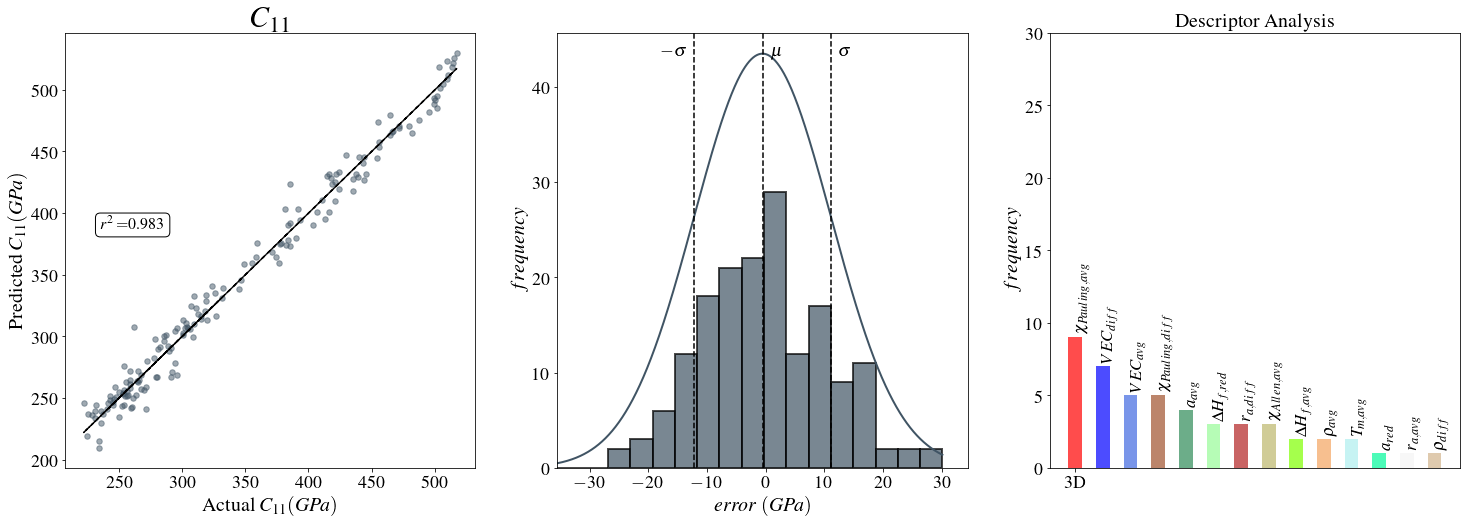

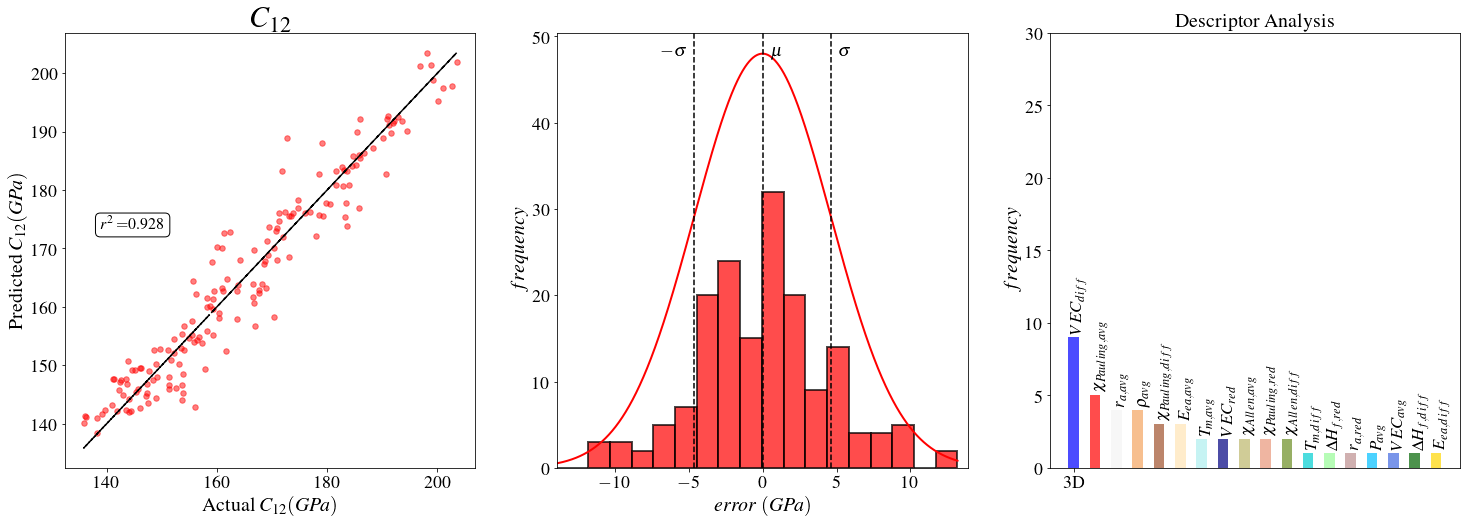

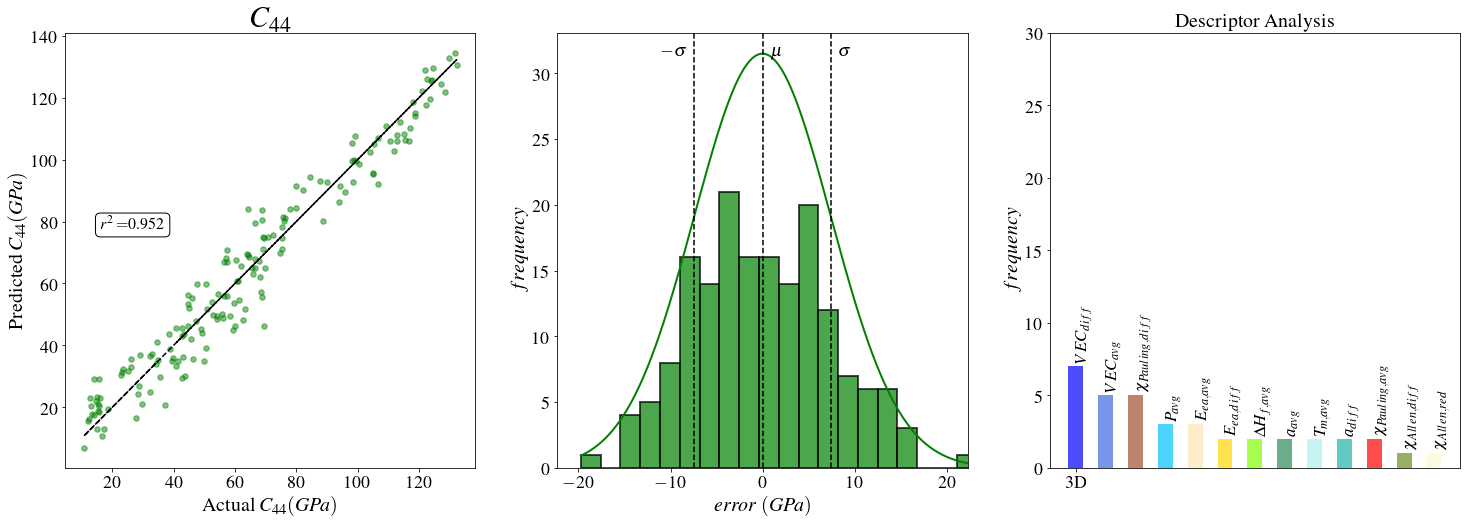

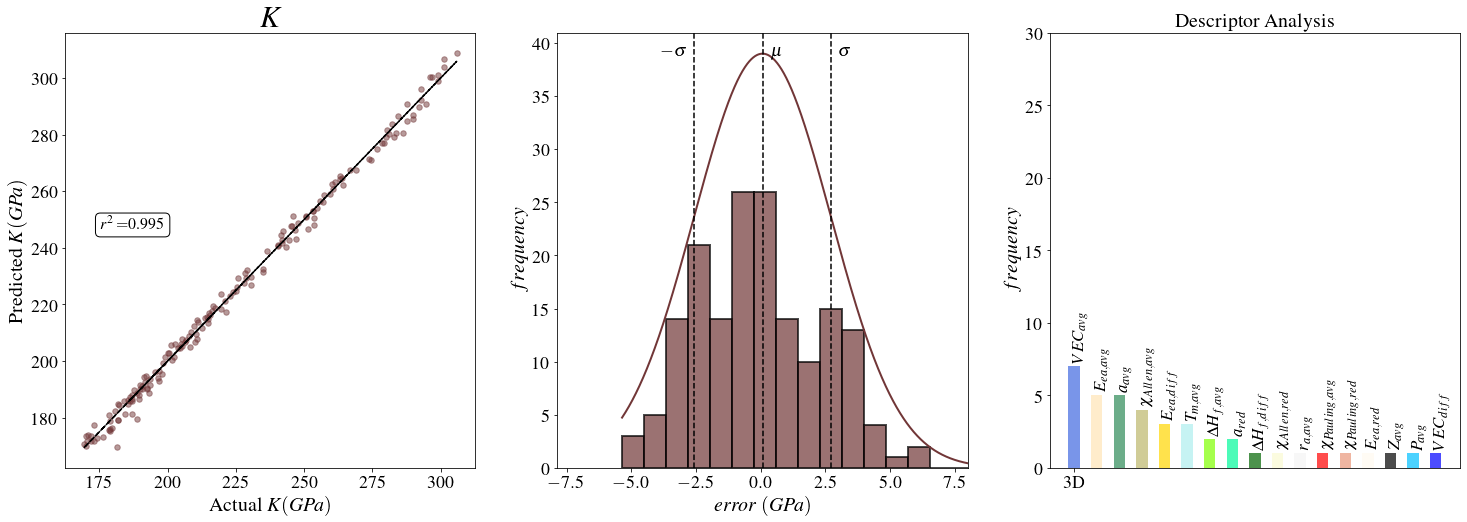

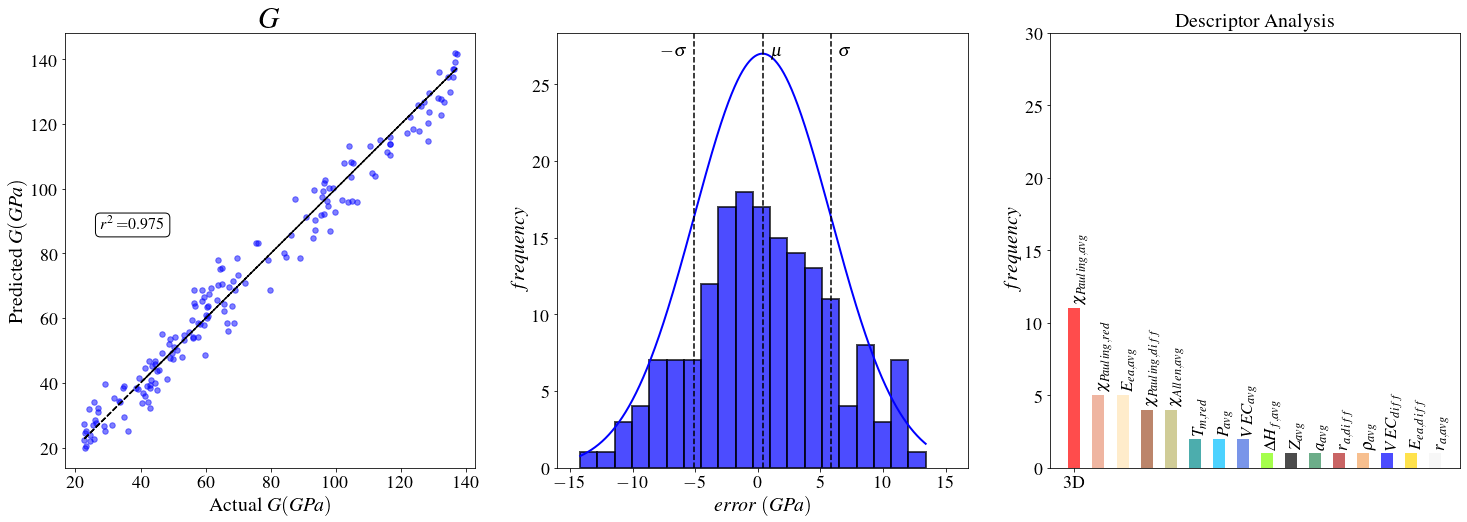

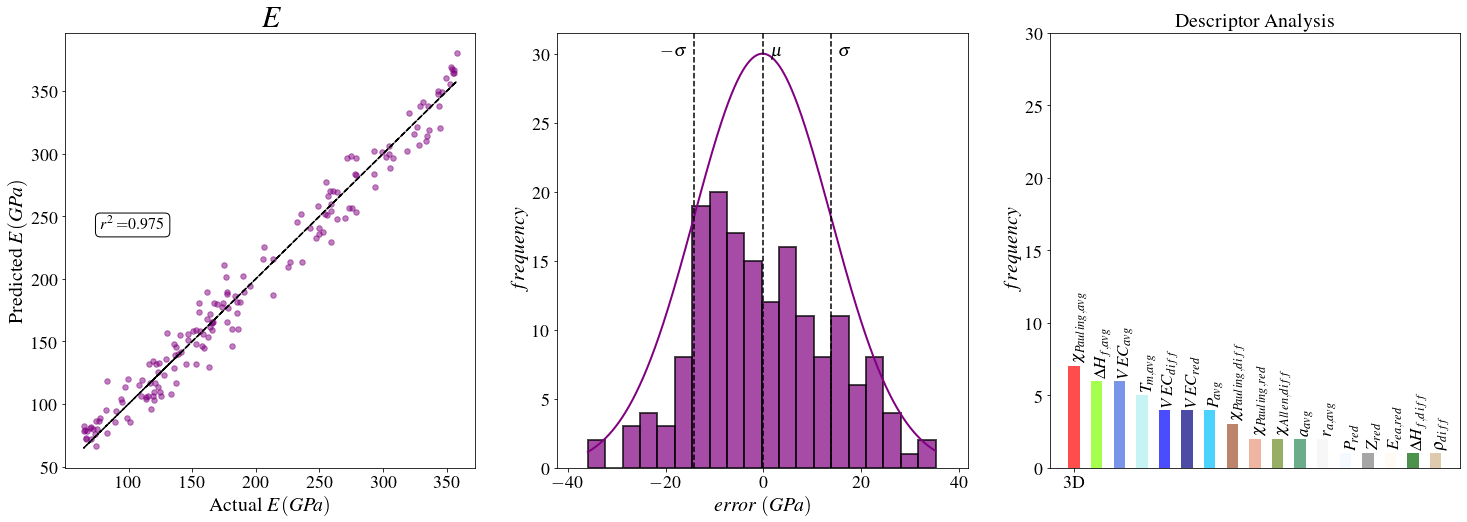

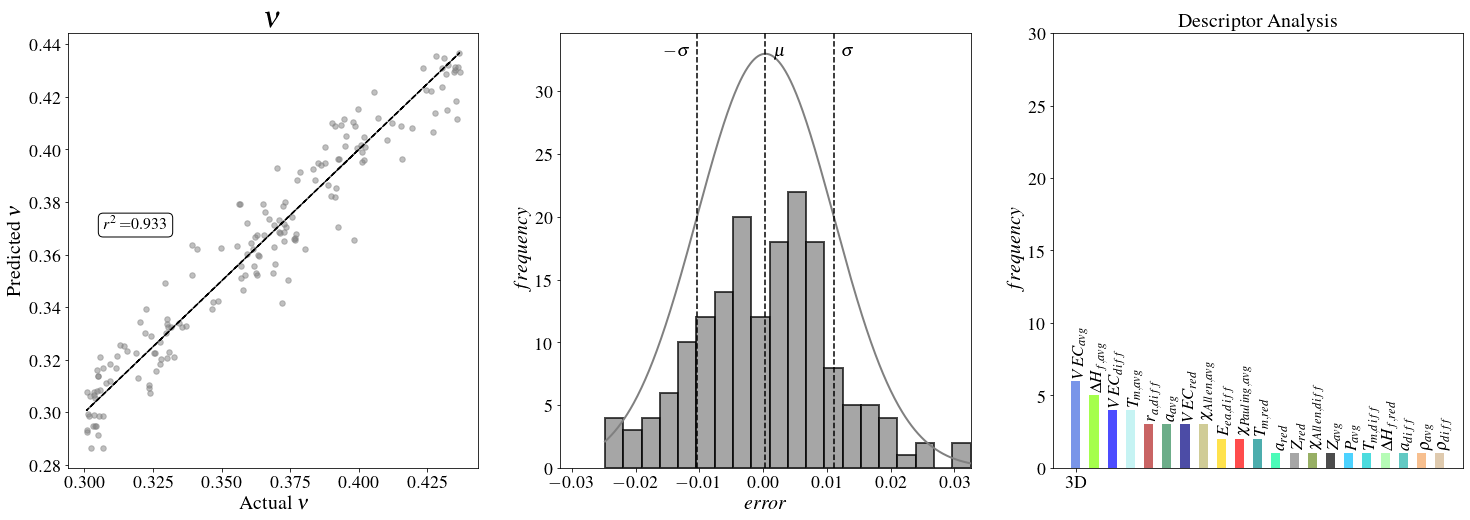

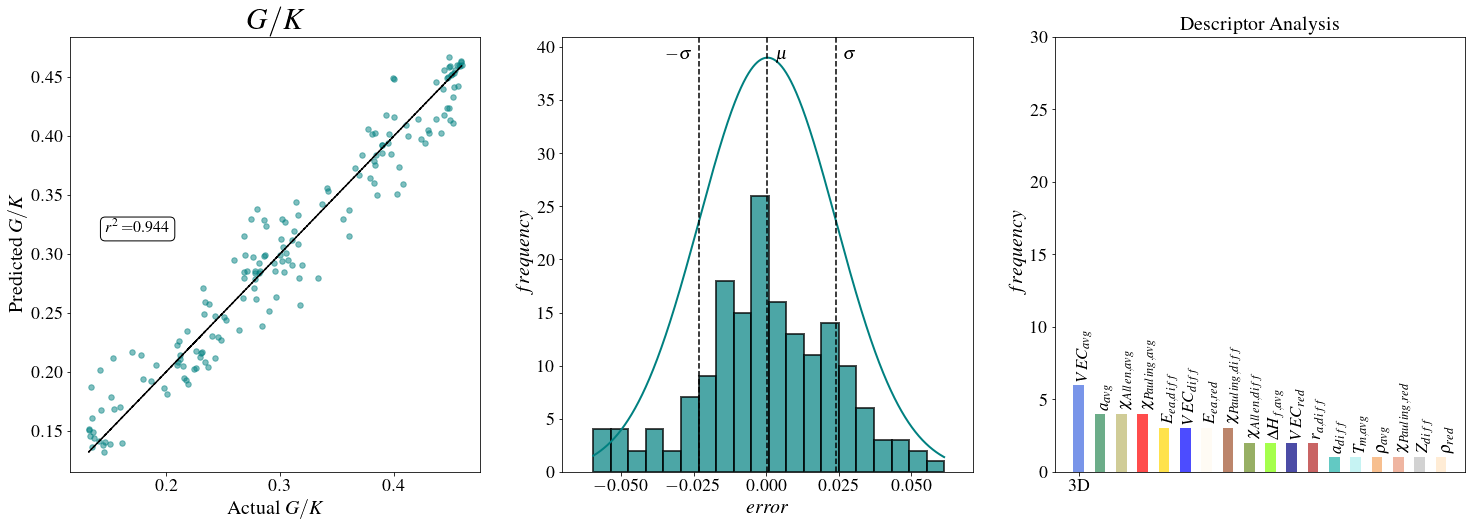

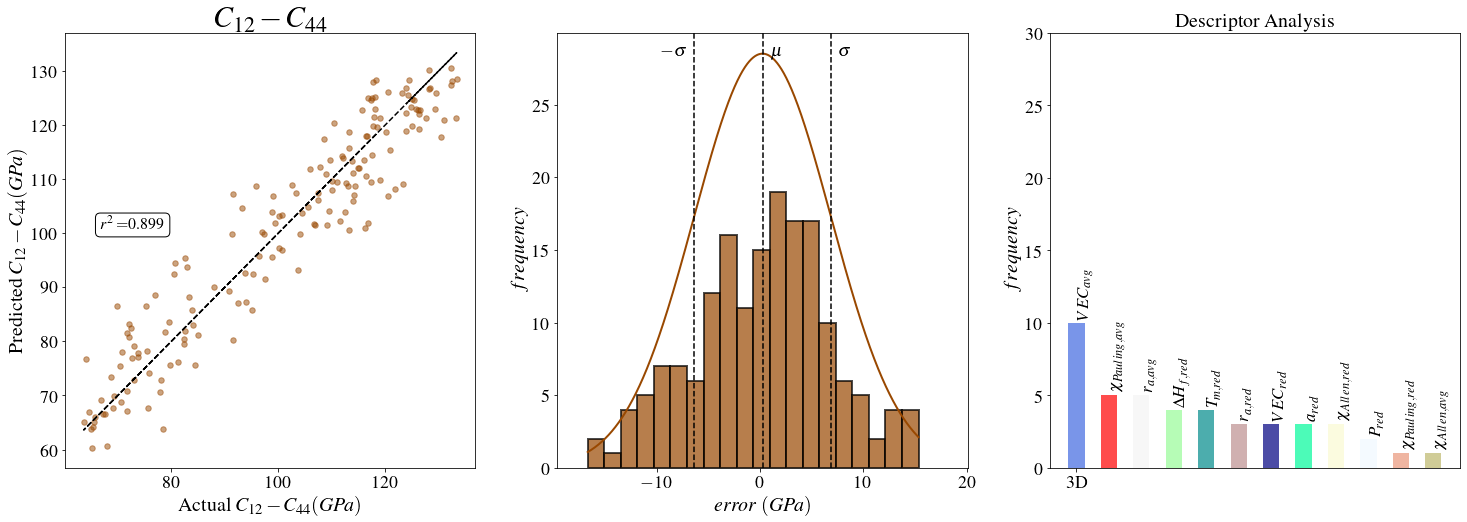

In [12]:
CVcase='05'
for c in range(9):
    a_p=[1]

    fs=20
    colorm=['#405464','r','g','#713637','b','purple','gray','teal','#994800']

    fig, ax = plt.subplots(1,3,figsize=(25,8))
    plt.subplots_adjust(hspace = 0.05,)
    #c=0
    case=['C_11','C_12','C_44','K','G','E','v','GK','cauchy']
    for i in a_p:
        j=0
        df=pd.read_csv(d_f+'fromHPRC/'+case[c]+'.avgvar'+CVcase+'/Results3D', delim_whitespace=True)
        ax[j].scatter(df['Y'],df['Y_pred'],color=colorm[c],s=30,alpha=0.5)
        ax[j].plot(df['Y'],df['Y'],'--k')
        ax[j].annotate(r'$r^2=$'+'{:1.3f}'.format(round(r2_score(df['Y'],df['Y_pred']),4))
                      , xy=(100, 250), xycoords='axes points',
          size=16, ha='right', va='top',
          bbox=dict(boxstyle='round', fc='w'))
        j=1


        label=df['diff']
        label=np.sort(label)
        yh,xh,_=ax[j].hist(label, 20,edgecolor='k',color=colorm[c], linewidth=2,alpha=0.7)
        x=np.arange(label.min(),label.max(),0.0001)
        y=stats.norm.pdf(x,label.mean(),label.std())
        scale=1.5*yh.max()/y.max()
        ax[j].plot(x,y*scale,'-',color=colorm[c], linewidth=2)
        
        frame1 = plt.gca()
        left = frame1.axes.spines["left"]
        right_side = frame1.axes.spines["right"]
        top = frame1.axes.spines["top"]

        ax[j].set_ylabel(r'$frequency$',fontsize=20)
        if c in [6,7]:
            ax[j].set_xlabel(r'$error$',fontsize=20)
        else:
            ax[j].set_xlabel(r'$error$ $(GPa)$',fontsize=20)
        ####
        ax[j].axvline(label.mean(),color='k',ls='--')
        ax[j].annotate(r'$\mu$',xy=(0.52, 0.95),xycoords='axes fraction')
        ax[j].axvline(label.mean()-label.std(),color='k',ls='--')
        ax[j].annotate(r'$-\sigma$',xy=(0.5 - (1/6) - 0.08, 0.95),xycoords='axes fraction')
        ax[j].axvline(label.mean()+label.std(),color='k',ls='--')
        ax[j].annotate(r'$\sigma$',xy=(0.5 + (1/6) + 0.02, 0.95),xycoords='axes fraction')
        ax[j].set_xlim([label.mean()-3*label.std(),label.mean()+3*label.std()])
        ####
        j=2

        lab_mm,val_mm,imp_col,imp_lab=get4Dfreq(d_f+'fromHPRC/'+case[c]+'.avgvar'+CVcase+'/',3)

        #l_plot = ['1D', '2D', '3D', '4D']
        l_plot = ['3D']
        co=0
        x=[]
        width = 0.5  # the width of the bars

        for ii in range(2,len(val_mm)):
            for jj in range(len(val_mm[ii])):
                ax[j].bar(co,val_mm[ii][jj],width=width,color=imp_col[ii][jj],alpha=0.7)
                ax[j].annotate(#'{}'.format(height),
                '{}'.format(imp_lab[ii][jj]),
                xy=(co + width / 2, val_mm[ii][jj]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',rotation=90, fontsize=17)
                co=co+1
            if ii !=len(val_mm)-1:
                plt.axvline(co,color='k')
            x.append(co-len(val_mm[ii]))
            co=co+1

        ax[j].set_ylabel(r'$frequency$',fontsize=20)
        ax[j].set_title(r'Descriptor Analysis',fontsize=20,fontname='Times')
        ax[j].set_yticks([0,5,10,15,20,25,30])
        ax[j].set_xticks(x)
        ax[j].set_xticklabels(l_plot)
        ax[j].set_ylim(0,30)





    case_latex=['C_{11}','C_{12}','C_{44}','K','G','E','\\nu','G/K','C_{12}-C_{44}']

    for i in a_p:
        ii=0
        j=0
        if c in [6,7]:
            ax[j].set_xlabel('Actual $'+case_latex[c]+'$', fontsize=fs)
            ax[j].set_ylabel('Predicted $'+case_latex[c]+'$', fontsize=fs)
        else:
            ax[j].set_xlabel('Actual $'+case_latex[c]+'(GPa)$', fontsize=fs)
            ax[j].set_ylabel('Predicted $'+case_latex[c]+'(GPa)$', fontsize=fs)
        ax[j].set_title('$'+case_latex[c]+'$', fontsize=fs+10)

    #plt.savefig(str(case[c])+'dpi'+str(dpi)+'-'+CVcase+'.png',dpi=dpi,)

## Paper format 05

plotting each loop for images available in the draft

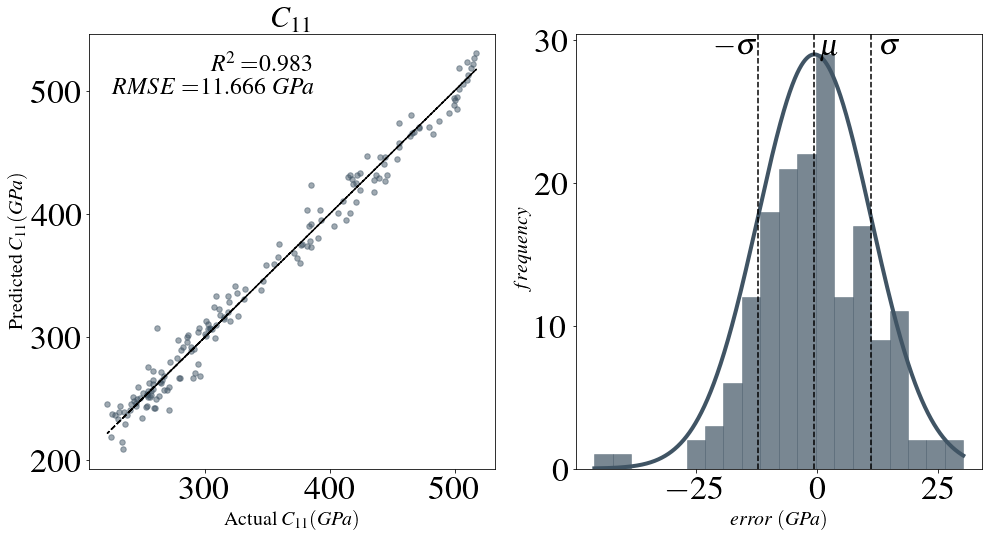

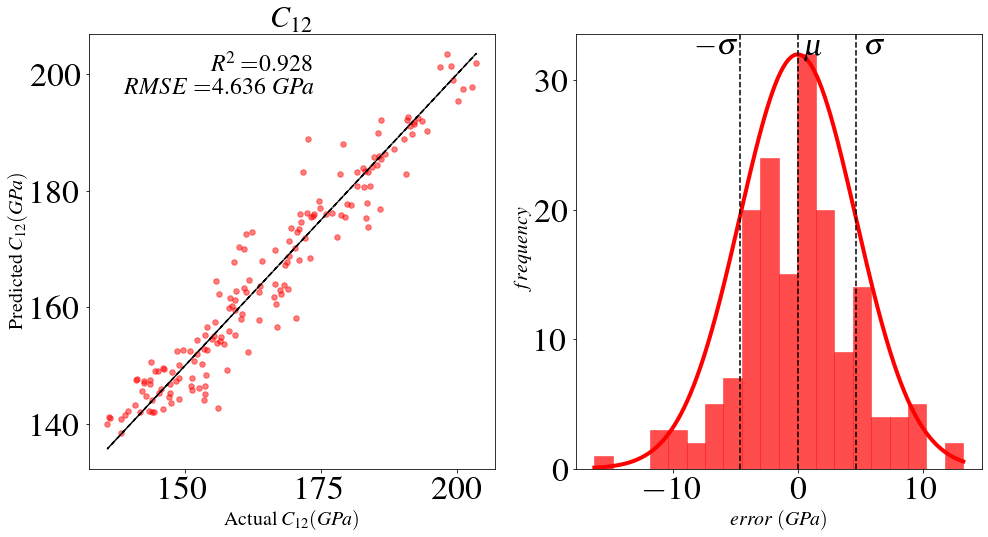

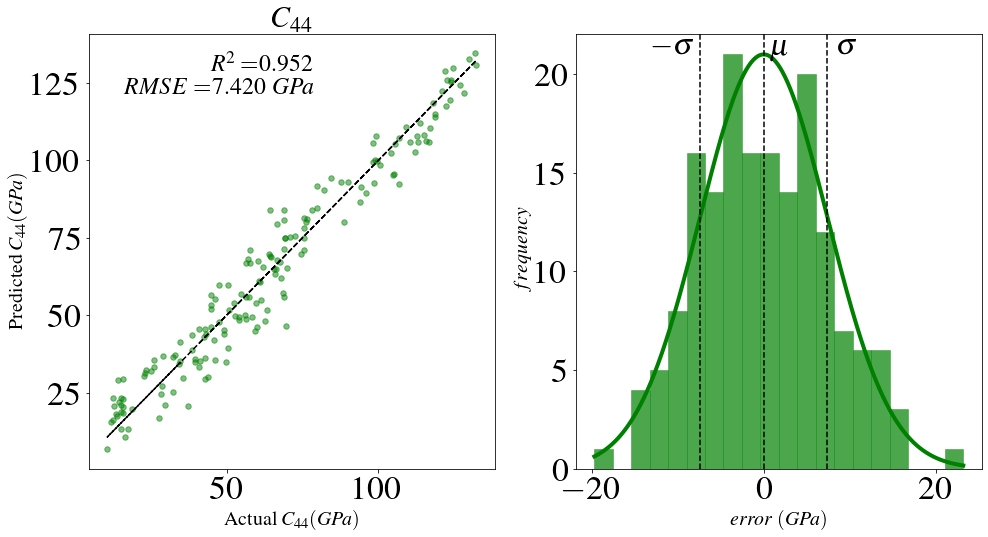

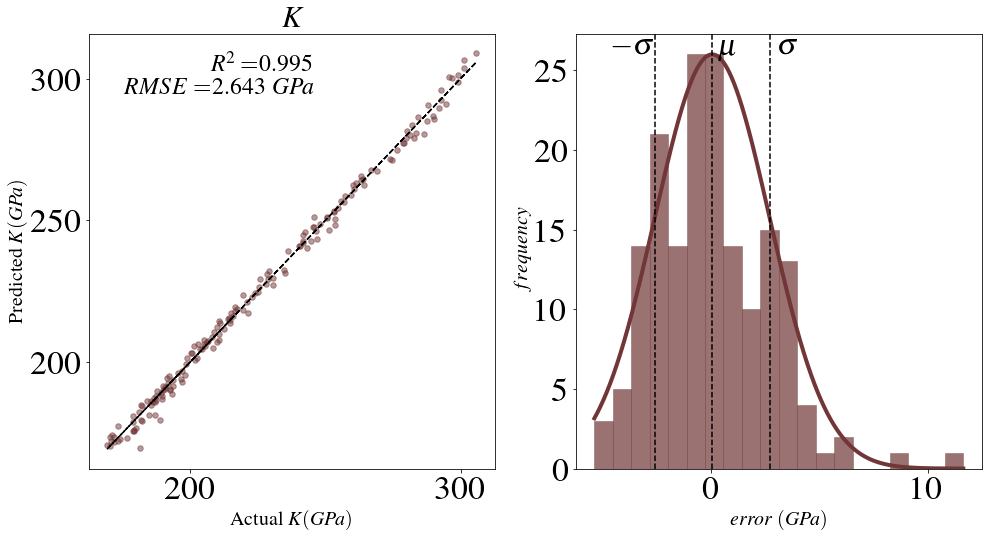

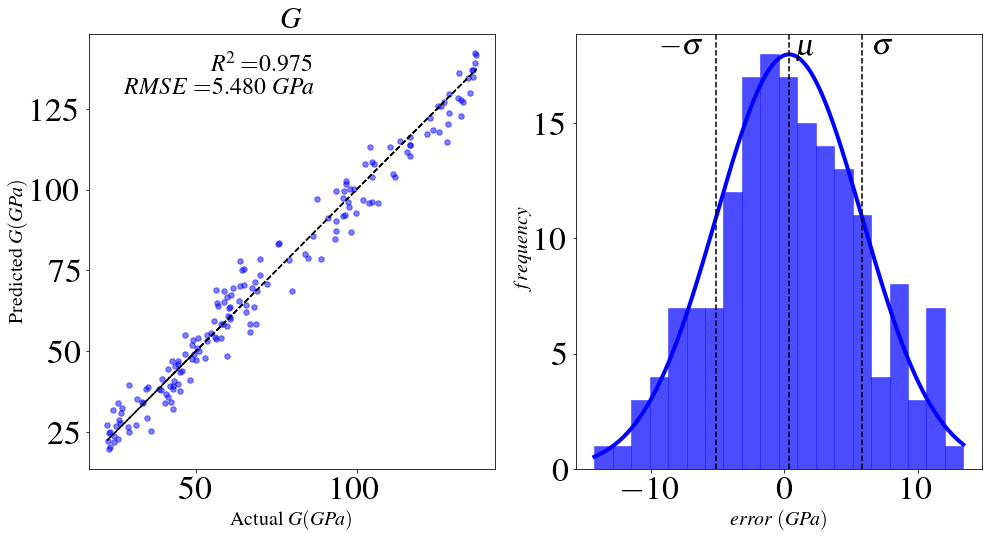

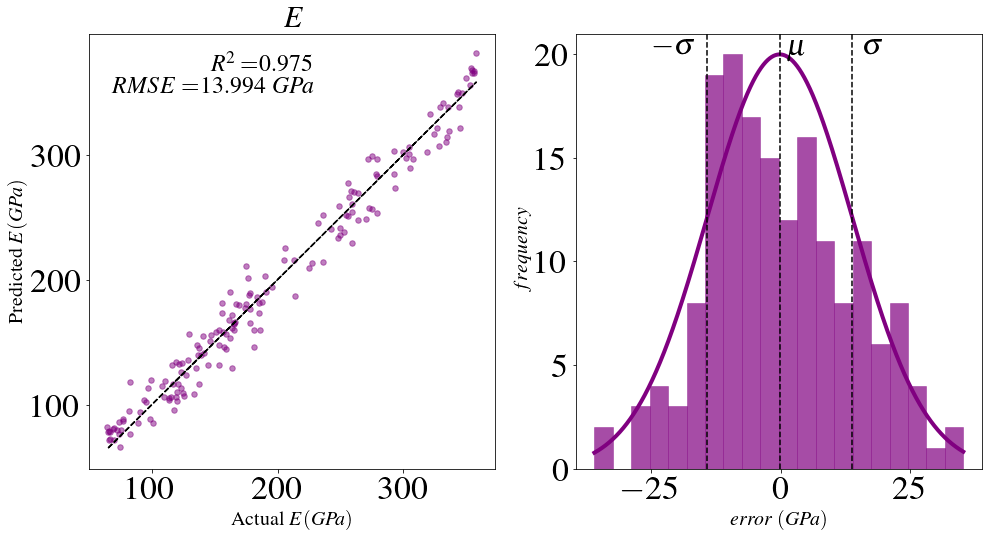

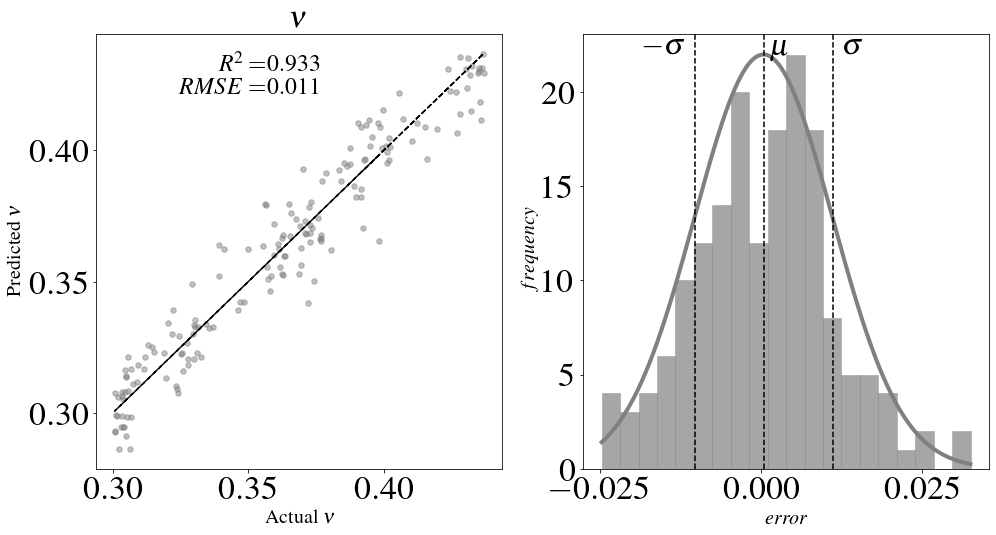

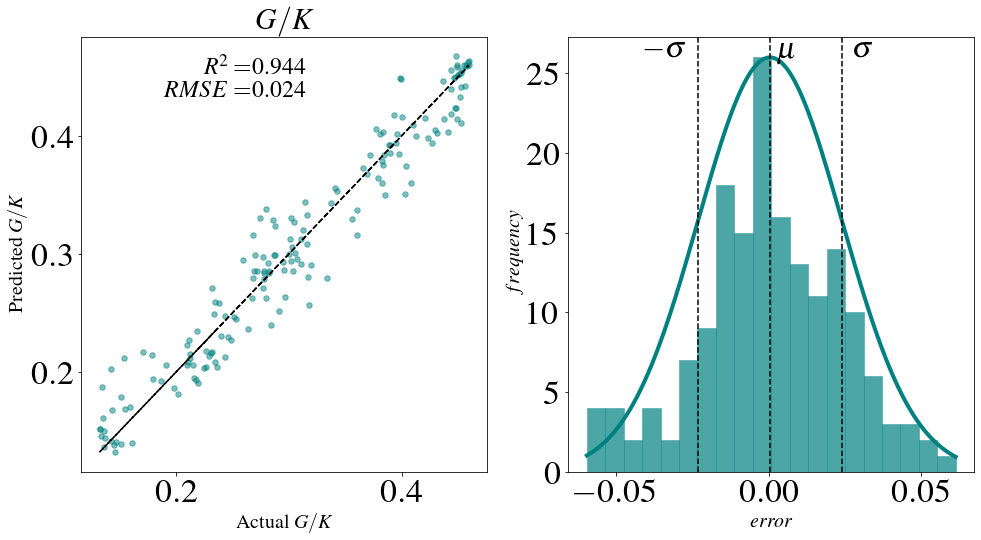

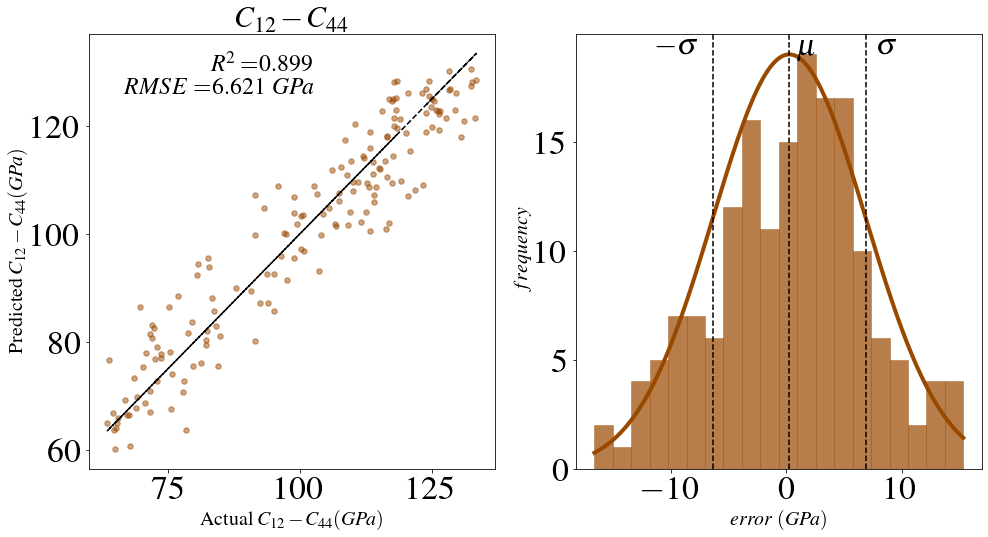

In [13]:
CVcase='05'
plt.rcParams.update({'font.size': 34})

for c in range(9):
    a_p=[1]

    fs=20
    colorm=['#405464','r','g','#713637','b','purple','gray','teal','#994800']

    fig, ax = plt.subplots(1,2,figsize=(16,8))
    plt.subplots_adjust(hspace = 0.05,)
    
    case=['C_11','C_12','C_44','K','G','E','v','GK','cauchy']
    for i in a_p:
        j=0
        df=pd.read_csv(d_f+'fromHPRC/'+case[c]+'.avgvar'+CVcase+'/Results3D', delim_whitespace=True)
        ax[j].scatter(df['Y'],df['Y_pred'],color=colorm[c],s=30,alpha=0.5)
        ax[j].plot(df['Y'],df['Y'],'--k')
        
        
        ax[j].annotate(r'$R^2=$'+'{:1.3f}'.format(round(r2_score(df['Y'],df['Y_pred']),4))
                      , xy=(0.55, 0.95), xycoords='axes fraction',
          size=24, ha='right', va='top',)
          
        
        if c in [6,7]:
            ax[j].annotate(r'$RMSE=$'+'{:1.3f}'.format(round(np.sqrt(mean_squared_error(df['Y'],df['Y_pred'])),4))
                          , xy=(0.55, 0.9), xycoords='axes fraction',
              size=24, ha='right', va='top',)
              
        else:
            ax[j].annotate(r'$RMSE=$'+'{:1.3f}'.format(round(np.sqrt(mean_squared_error(df['Y'],df['Y_pred'])),4))+' $GPa$'                         , xy=(0.55, 0.9), xycoords='axes fraction',
              size=24, ha='right', va='top',)
              

        
        
        j=1


        label=df['diff']
        label=np.sort(label)
        yh,xh,_=ax[j].hist(label, 20,edgecolor=colorm[c],color=colorm[c], linewidth=0.5,alpha=0.7)
        x=np.arange(label.min(),label.max(),0.0001)
        y=stats.norm.pdf(x,label.mean(),label.std())
        scale=1*yh.max()/y.max()
        ax[j].plot(x,y*scale,'-',color=colorm[c], linewidth=4)
        

        
        
        
        frame1 = plt.gca()
        
        left = frame1.axes.spines["left"]
        right_side = frame1.axes.spines["right"]
        top = frame1.axes.spines["top"]

        ax[j].set_ylabel(r'$frequency$',fontsize=20)
        if c in [6,7]:
            ax[j].set_xlabel(r'$error$',fontsize=20)
        else:
            ax[j].set_xlabel(r'$error$ $(GPa)$',fontsize=20)
        ####
        ax[j].axvline(label.mean(),color='k',ls='--')
        ax[j].annotate(r'$\mu$',xy=(label.mean()+label.std()*0.1, scale*y.max()),xycoords='data',fontsize=30,weight='bold')
        ax[j].axvline(label.mean()-label.std(),color='k',ls='--')
        ax[j].annotate(r'$-\sigma$',xy=(label.mean()-label.std()*1.75,  scale*y.max()),xycoords='data',fontsize=30,weight='bold')
        ax[j].axvline(label.mean()+label.std(),color='k',ls='--')
        ax[j].annotate(r'$\sigma$',xy=(label.mean()+label.std()*1.15, scale*y.max()),xycoords='data',fontsize=30,weight='bold')
        
        

    case_latex=['C_{11}','C_{12}','C_{44}','K','G','E','\\nu','G/K','C_{12}-C_{44}']

    for i in a_p:
        ii=0
        j=0
        if c in [6,7]:
            ax[j].set_xlabel('Actual $'+case_latex[c]+'$', fontsize=fs)
            ax[j].set_ylabel('Predicted $'+case_latex[c]+'$', fontsize=fs)
        else:
            ax[j].set_xlabel('Actual $'+case_latex[c]+'(GPa)$', fontsize=fs)
            ax[j].set_ylabel('Predicted $'+case_latex[c]+'(GPa)$', fontsize=fs)
        ax[j].set_title('$'+case_latex[c]+'$', fontsize=fs+10)

    #plt.savefig(str(case[c])+'dpi'+str(dpi)+'-'+CVcase+'.png',dpi=dpi,)
    #plt.show(str(case[c])+'-10.png',dpi=200,)

## Paper format CV 10

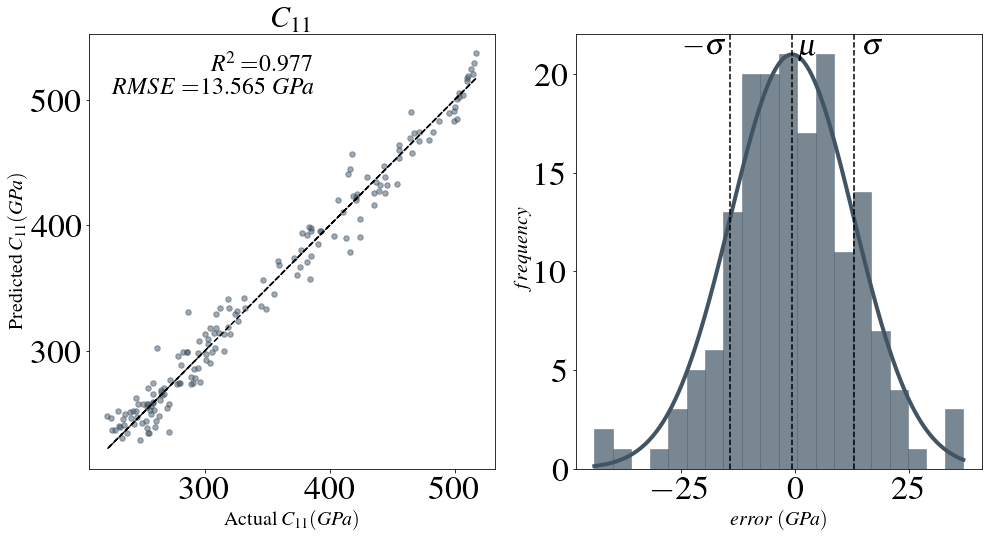

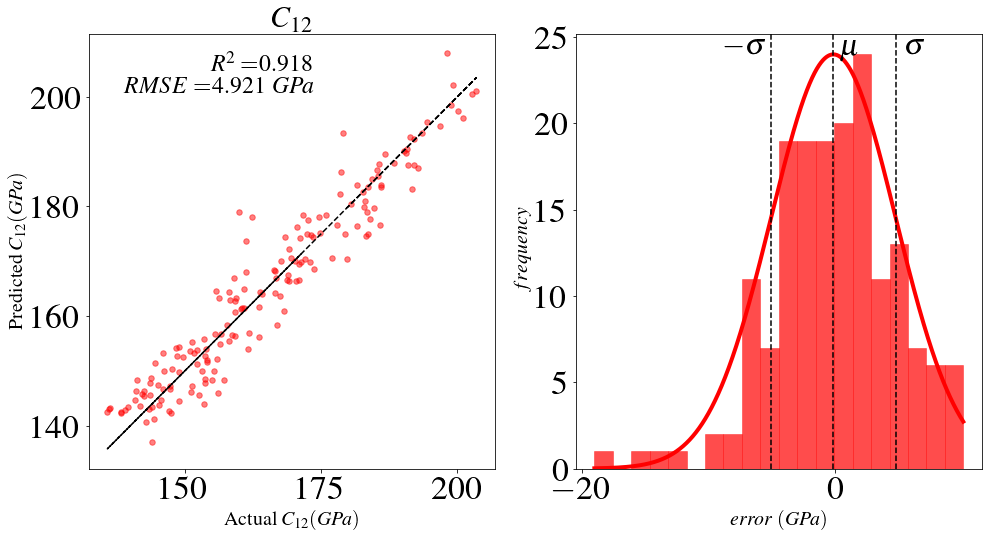

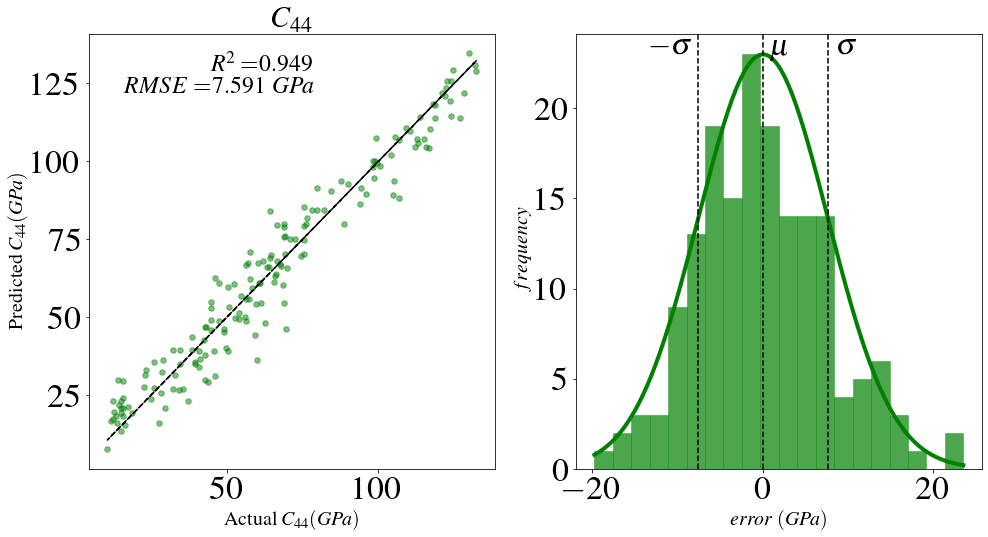

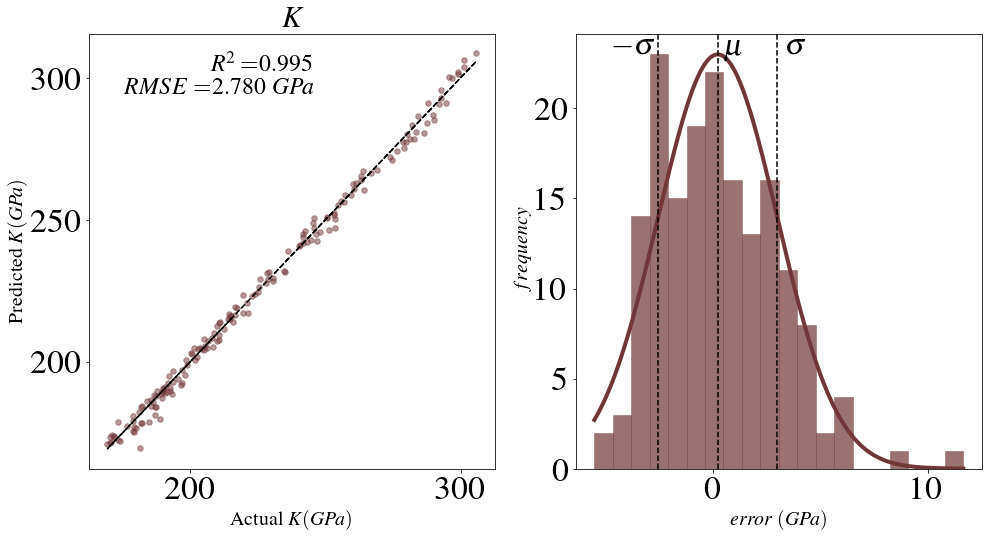

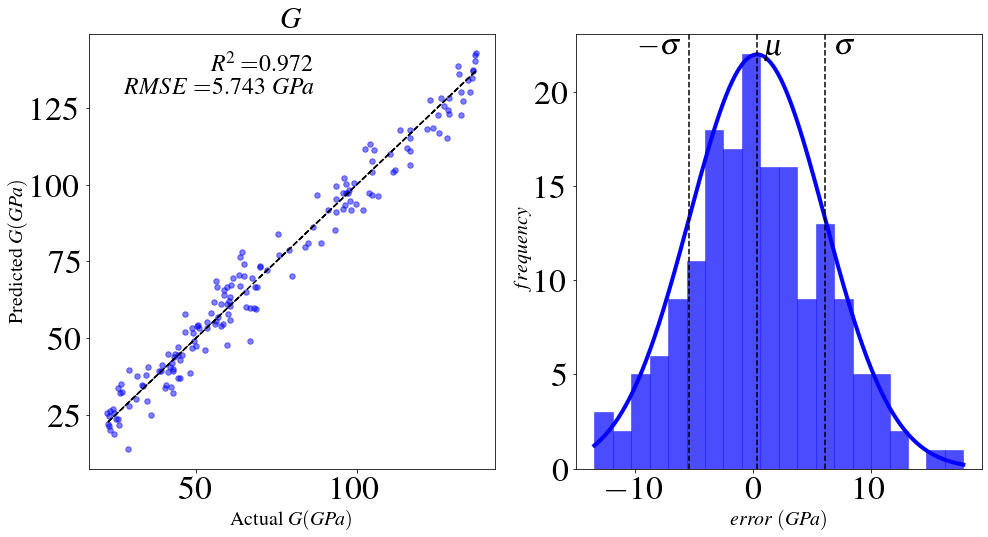

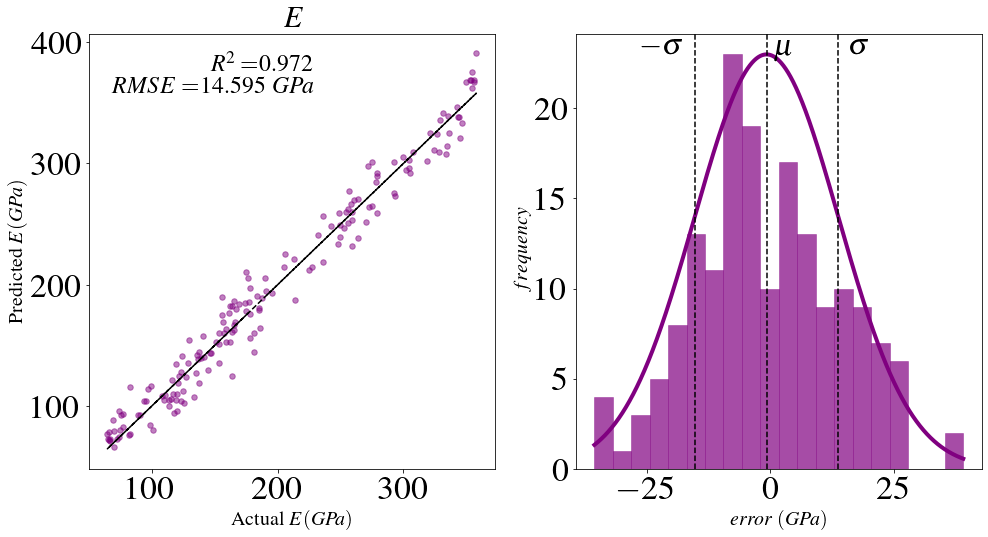

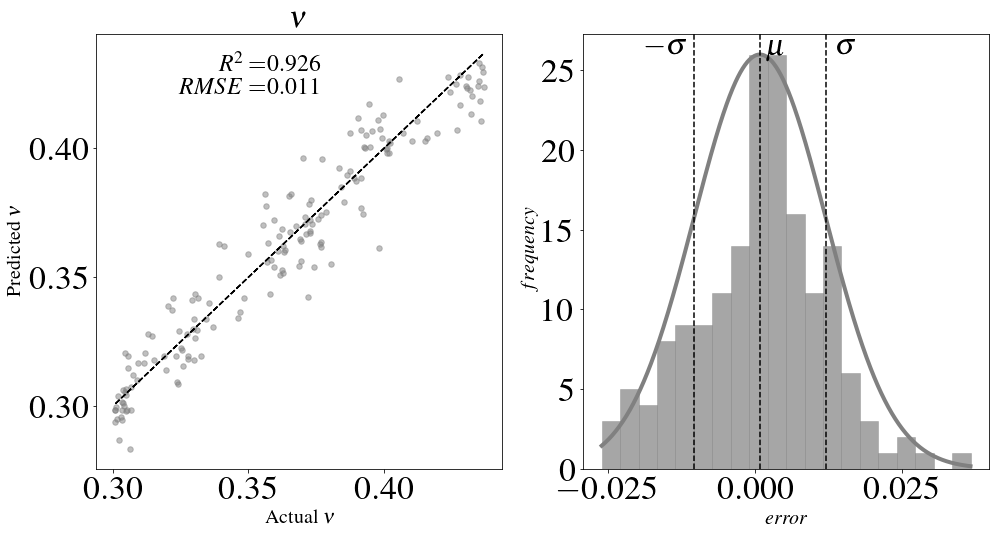

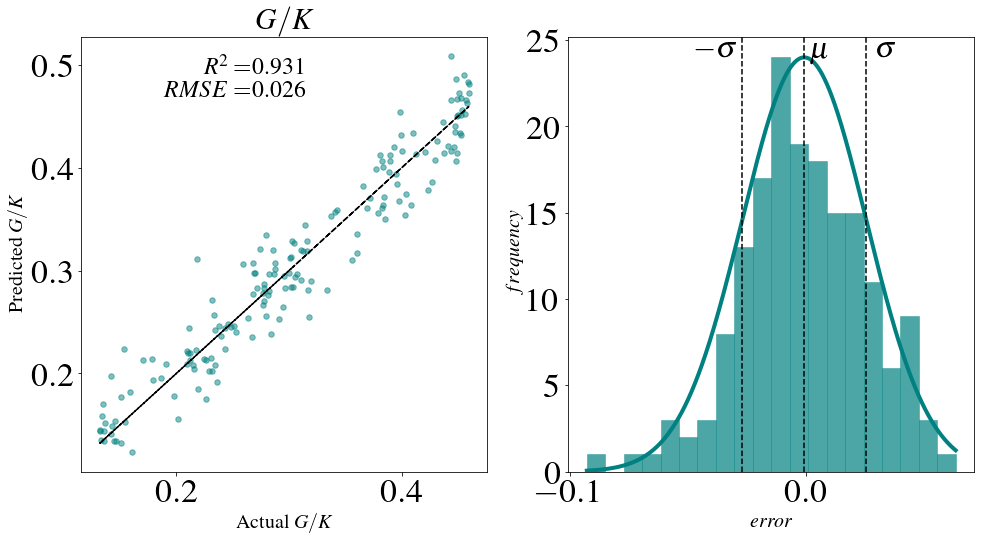

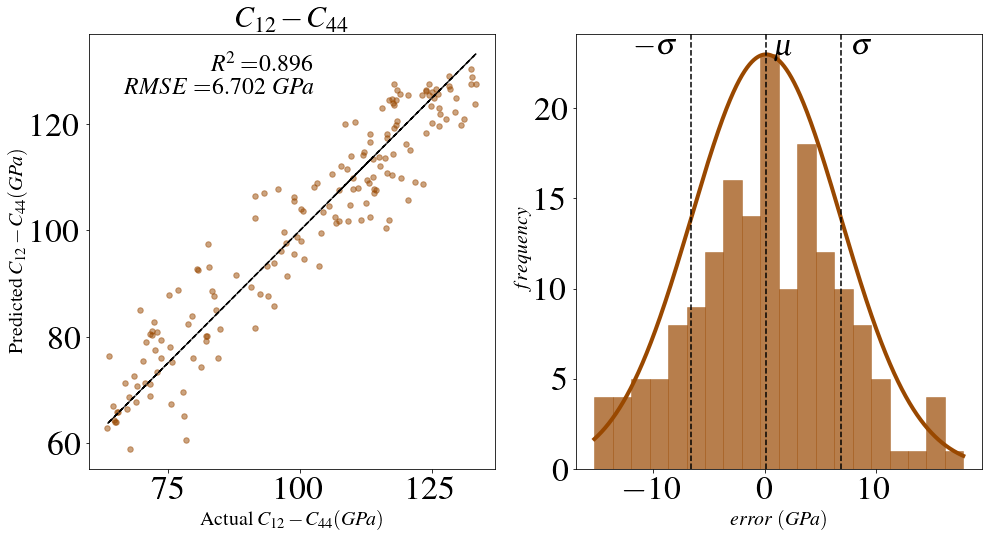

In [14]:
CVcase='10'
plt.rcParams.update({'font.size': 34})

for c in range(9):
    a_p=[1]

    fs=20
    colorm=['#405464','r','g','#713637','b','purple','gray','teal','#994800']

    fig, ax = plt.subplots(1,2,figsize=(16,8))
    plt.subplots_adjust(hspace = 0.05,)
    
    case=['C_11','C_12','C_44','K','G','E','v','GK','cauchy']
    for i in a_p:
        j=0
        df=pd.read_csv(d_f+'fromHPRC/'+case[c]+'.avgvar'+CVcase+'/Results3D', delim_whitespace=True)
        ax[j].scatter(df['Y'],df['Y_pred'],color=colorm[c],s=30,alpha=0.5)
        ax[j].plot(df['Y'],df['Y'],'--k')
        
        
        ax[j].annotate(r'$R^2=$'+'{:1.3f}'.format(round(r2_score(df['Y'],df['Y_pred']),4))
                      , xy=(0.55, 0.95), xycoords='axes fraction',
          size=24, ha='right', va='top',)
          
        
        if c in [6,7]:
            ax[j].annotate(r'$RMSE=$'+'{:1.3f}'.format(round(np.sqrt(mean_squared_error(df['Y'],df['Y_pred'])),4))
                          , xy=(0.55, 0.9), xycoords='axes fraction',
              size=24, ha='right', va='top',)
              
        else:
            ax[j].annotate(r'$RMSE=$'+'{:1.3f}'.format(round(np.sqrt(mean_squared_error(df['Y'],df['Y_pred'])),4))+' $GPa$'                         , xy=(0.55, 0.9), xycoords='axes fraction',
              size=24, ha='right', va='top',)
              

        
        
        j=1


        label=df['diff']
        label=np.sort(label)
        yh,xh,_=ax[j].hist(label, 20,edgecolor=colorm[c],color=colorm[c], linewidth=0.5,alpha=0.7)
        x=np.arange(label.min(),label.max(),0.0001)
        y=stats.norm.pdf(x,label.mean(),label.std())
        scale=1*yh.max()/y.max()
        ax[j].plot(x,y*scale,'-',color=colorm[c], linewidth=4)
        

        
        
        
        frame1 = plt.gca()
        
        left = frame1.axes.spines["left"]
        right_side = frame1.axes.spines["right"]
        top = frame1.axes.spines["top"]

        ax[j].set_ylabel(r'$frequency$',fontsize=20)
        if c in [6,7]:
            ax[j].set_xlabel(r'$error$',fontsize=20)
        else:
            ax[j].set_xlabel(r'$error$ $(GPa)$',fontsize=20)
        ####
        ax[j].axvline(label.mean(),color='k',ls='--')
        ax[j].annotate(r'$\mu$',xy=(label.mean()+label.std()*0.1, scale*y.max()),xycoords='data',fontsize=30,weight='bold')
        ax[j].axvline(label.mean()-label.std(),color='k',ls='--')
        ax[j].annotate(r'$-\sigma$',xy=(label.mean()-label.std()*1.75,  scale*y.max()),xycoords='data',fontsize=30,weight='bold')
        ax[j].axvline(label.mean()+label.std(),color='k',ls='--')
        ax[j].annotate(r'$\sigma$',xy=(label.mean()+label.std()*1.15, scale*y.max()),xycoords='data',fontsize=30,weight='bold')
        
        

    case_latex=['C_{11}','C_{12}','C_{44}','K','G','E','\\nu','G/K','C_{12}-C_{44}']

    for i in a_p:
        ii=0
        j=0
        if c in [6,7]:
            ax[j].set_xlabel('Actual $'+case_latex[c]+'$', fontsize=fs)
            ax[j].set_ylabel('Predicted $'+case_latex[c]+'$', fontsize=fs)
        else:
            ax[j].set_xlabel('Actual $'+case_latex[c]+'(GPa)$', fontsize=fs)
            ax[j].set_ylabel('Predicted $'+case_latex[c]+'(GPa)$', fontsize=fs)
        ax[j].set_title('$'+case_latex[c]+'$', fontsize=fs+10)

    #plt.savefig(str(case[c])+'dpi'+str(dpi)+'-'+CVcase+'.png',dpi=dpi,)
    #plt.show(str(case[c])+'-10.png',dpi=200,)

## feature frequency analysis small image

feature frequency image isolated to obatain draf plots

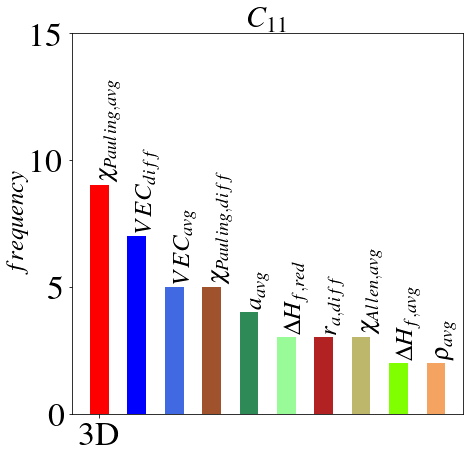

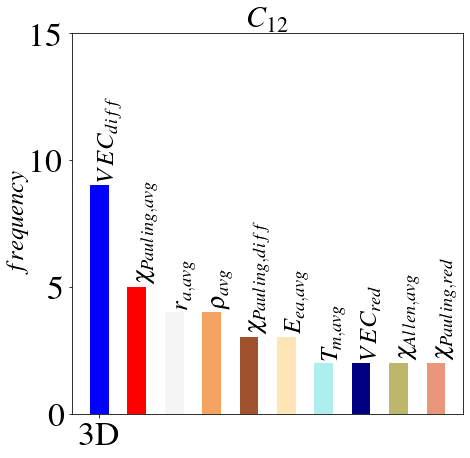

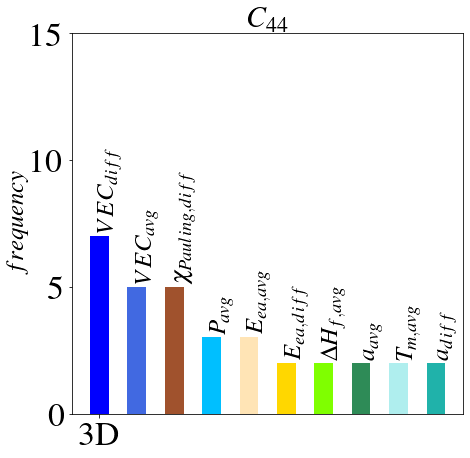

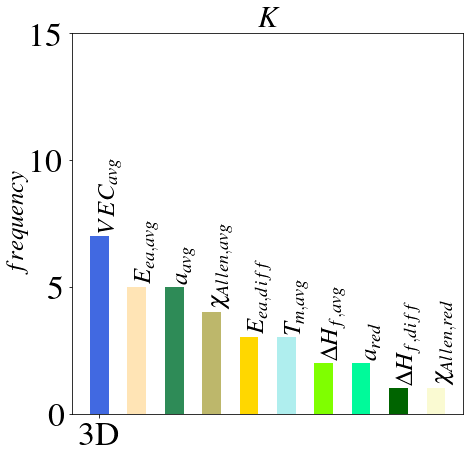

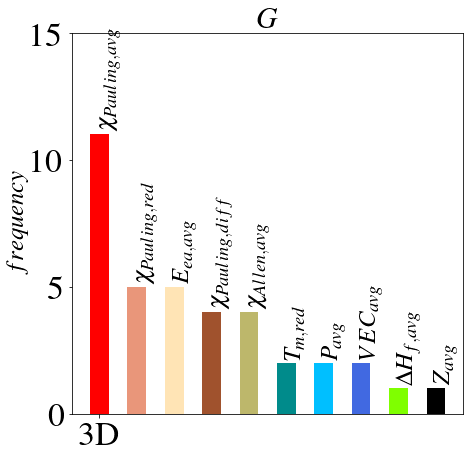

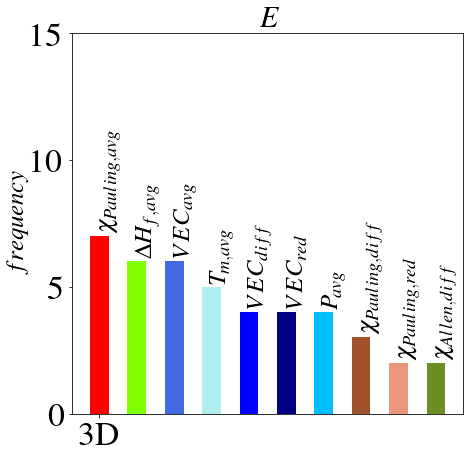

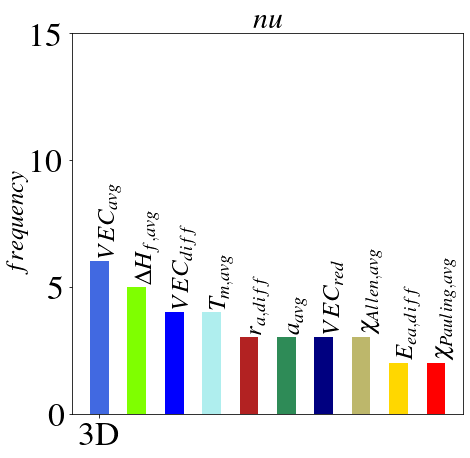

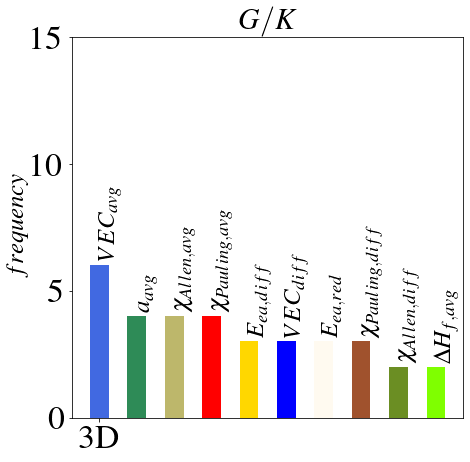

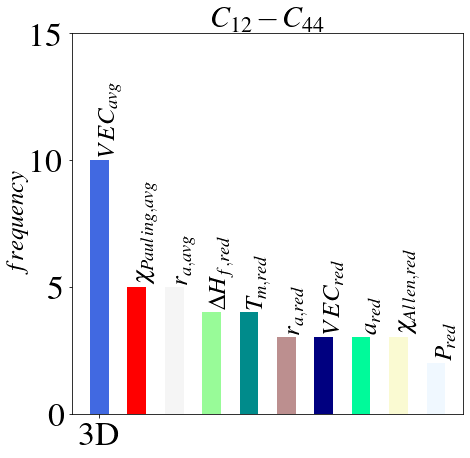

In [15]:
CVcase='05'
case_latex=[r'$C_{11}$',r'$C_{12}$',r'$C_{44}$',r'$K$',r'$G$',r'$E$',r'$\\nu$',r'$G/K$',r'$C_{12}-C_{44}$']

for c in range(9):
    a_p=[1]

    fs=20
    colorm=['#405464','r','g','#713637','b','purple','gray','teal','#994800']

    fig, ax = plt.subplots(1,1,figsize=(7,7))
    plt.subplots_adjust(hspace = 0.05,)
    case=['C_11','C_12','C_44','K','G','E','v','GK','cauchy']
    for i in a_p:
        j=0

        lab_mm,val_mm,imp_col,imp_lab=get4Dfreq(d_f+'fromHPRC/'+case[c]+'.avgvar'+CVcase+'/',3)
        l_plot = ['3D']
        co=0
        x=[]
        width = 0.5

        for ii in range(2,len(val_mm)):
            for jj in range(10):
                ax.bar(co,val_mm[ii][jj],width=width,color=imp_col[ii][jj])
                ax.annotate(#'{}'.format(height),
                '{}'.format(imp_lab[ii][jj]),
                xy=(co + width / 2, val_mm[ii][jj]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',rotation=90, fontsize=25)
                co=co+1
            if ii !=len(val_mm)-1:
                plt.axvline(co,color='k')
            x.append(co-10)#len(val_mm[ii]))
            co=co+1
            
        ax.set_ylabel(r'$frequency$',fontsize=25,labelpad=2)
        ax.set_title(case_latex[c],fontsize=30,fontname='Times')
        ax.set_yticks([0,5,10,15])
        ax.set_xticks(x)
        ax.set_xticklabels(l_plot)
        ax.set_ylim(0,15)
        
    #plt.savefig(str(case[c])+'dpi'+str(dpi)+'descriptor-'+CVcase+'.png',dpi=dpi,)

## r squared values for the final model

Final result values in RMSE and R^2

In [16]:
case=['C_11','C_12','C_44','K','G','E','v','GK','cauchy']
for i in case:
    print(i)
    df=pd.read_csv(d_f+'fromHPRC/'+i+'.avgvar00/Results3D', delim_whitespace=True)
    print(r'$R^2=$'+'{:1.3f}'.format(round(r2_score(df['Y'],df['Y_pred']),4)))
    print(r'$RMSE=$'+'{:1.2f}'.format(round(np.sqrt(mean_squared_error(df['Y'],df['Y_pred'])),4)))

C_11
$R^2=$0.986
$RMSE=$10.77
C_12
$R^2=$0.937
$RMSE=$4.31
C_44
$R^2=$0.956
$RMSE=$7.06
K
$R^2=$0.996
$RMSE=$2.37
G
$R^2=$0.979
$RMSE=$5.06
E
$R^2=$0.978
$RMSE=$13.10
v
$R^2=$0.948
$RMSE=$0.01
GK
$R^2=$0.952
$RMSE=$0.02
cauchy
$R^2=$0.908
$RMSE=$6.31


## r squared values for CV 05

In [17]:
case=['C_11','C_12','C_44','K','G','E','v','GK','cauchy']
for i in case:
    print(i)
    df=pd.read_csv(d_f+'fromHPRC/'+i+'.avgvar05/Results3D', delim_whitespace=True)
    print(r'$R^2=$'+'{:1.3f}'.format(round(r2_score(df['Y'],df['Y_pred']),4)))
    print(r'$RMSE=$'+'{:1.2f}'.format(round(np.sqrt(mean_squared_error(df['Y'],df['Y_pred'])),4)))

C_11
$R^2=$0.983
$RMSE=$11.67
C_12
$R^2=$0.928
$RMSE=$4.64
C_44
$R^2=$0.952
$RMSE=$7.42
K
$R^2=$0.995
$RMSE=$2.64
G
$R^2=$0.975
$RMSE=$5.48
E
$R^2=$0.975
$RMSE=$13.99
v
$R^2=$0.933
$RMSE=$0.01
GK
$R^2=$0.944
$RMSE=$0.02
cauchy
$R^2=$0.899
$RMSE=$6.62


## r squared values for CV 10

In [18]:
case=['C_11','C_12','C_44','K','G','E','v','GK','cauchy']
for i in case:
    print(i)
    df=pd.read_csv(d_f+'fromHPRC/'+i+'.avgvar10/Results3D', delim_whitespace=True)
    print(r'$R^2=$'+'{:1.3f}'.format(round(r2_score(df['Y'],df['Y_pred']),4)))
    print(r'$RMSE=$'+'{:1.2f}'.format(round(np.sqrt(mean_squared_error(df['Y'],df['Y_pred'])),4)))

C_11
$R^2=$0.977
$RMSE=$13.57
C_12
$R^2=$0.918
$RMSE=$4.92
C_44
$R^2=$0.949
$RMSE=$7.59
K
$R^2=$0.995
$RMSE=$2.78
G
$R^2=$0.972
$RMSE=$5.74
E
$R^2=$0.972
$RMSE=$14.60
v
$R^2=$0.926
$RMSE=$0.01
GK
$R^2=$0.931
$RMSE=$0.03
cauchy
$R^2=$0.896
$RMSE=$6.70
